/Users/gt/DATA/seisandata
2021-11-11-0203-31
Trying to load inventory from 2021/11/11 02:02 to 2021/11/11 02:06
inventory saved to /Users/gt/DATA/seisandata/CAL/Inventory.2021-11-11-0203-31.xml
Inventory created at 2021-11-12T21:26:12.012659Z
	Sending institution: SeisComP (RaspberryShake)
	Contains:
		Networks (1):
			AM
		Stations (1):
			AM.R1E5E (Raspberry Shake Citizen Science Station)
		Channels (3):
			AM.R1E5E.00.EHZ, AM.R1E5E.00.EHN, AM.R1E5E.00.EHE
['AM.R1E5E.EHE', 'AM.R1E5E.EHN', 'AM.R1E5E.EHZ']
AM.R1E5E.EHE
net=AM, station=R1E5E, chancode=EHE
AM.R1E5E.EHN
net=AM, station=R1E5E, chancode=EHN
AM.R1E5E.EHZ
net=AM, station=R1E5E, chancode=EHZ
3 Trace(s) in Stream:
AM.R1E5E.00.EHE | 2021-11-11T02:02:31.004000Z - 2021-11-11T02:06:31.004000Z | 100.0 Hz, 24001 samples
AM.R1E5E.00.EHN | 2021-11-11T02:02:31.004000Z - 2021-11-11T02:06:31.004000Z | 100.0 Hz, 24001 samples
AM.R1E5E.00.EHZ | 2021-11-11T02:02:31.004000Z - 2021-11-11T02:06:31.004000Z | 100.0 Hz, 24001 samples


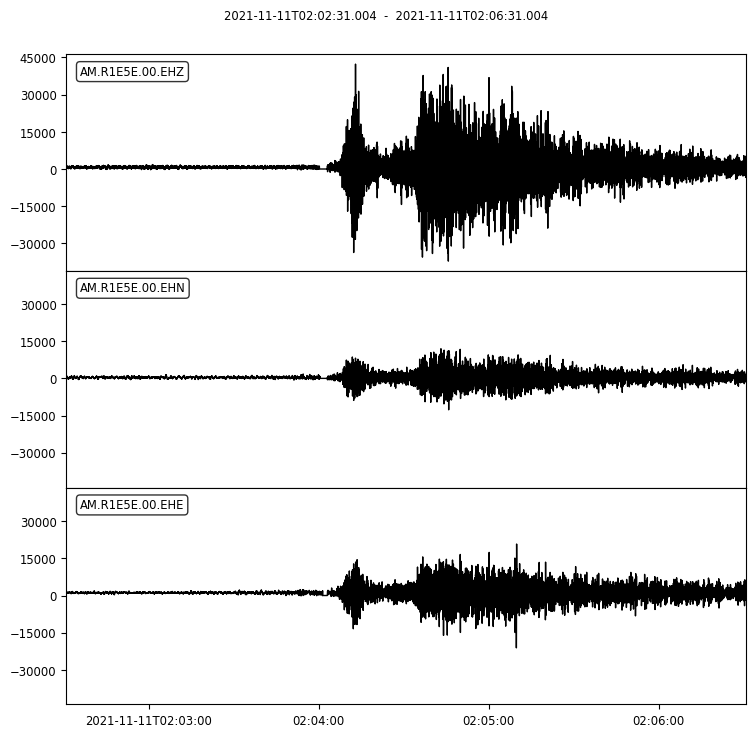

In [6]:
# imports
import pandas as pd
import os, sys
from obspy.clients.fdsn import Client
import obspy.core
#import glob
LIBpath = os.path.join( os.getenv('HOME'),'src','kitchensinkGT', 'LIB')
sys.path.append(LIBpath)
#from libseisGT import inventory2traceid, get_FDSN_inventory, get_FDSN_Stream, removeInstrumentResponse, detectEvent
from libseisGT import inventory2traceid, get_FDSN_inventory, get_FDSN_Stream
from libgeoGT import km2deg
#from metrics import eventStatistics

SEISAN_DATA = os.getenv('SEISAN_DATA')
if not SEISAN_DATA:
    SEISAN_DATA = os.path.join(os.getenv('HOME'), 'DATA', 'seisandata')
    if not os.path.exists(SEISAN_DATA):
        os.makedirs(SEISAN_DATA)
print(SEISAN_DATA)
masterEventFile = 'fdsn_catalog.csv'
df = pd.read_csv(masterEventFile)
eventTime = list()
for index, row in df.iterrows():
    thisEventTime = obspy.core.utcdatetime.UTCDateTime(row['time'])
    eventTime.append(thisEventTime)    
df['time'] = pd.Series(eventTime, index=df.index)

for i, row in df.iterrows():
    isofmt = row['time'].isoformat()
    wavtimeStr = isofmt[0:10] + "-" + isofmt[11:13] + isofmt[14:16] + "-" + isofmt[17:19]
    print(wavtimeStr)
    stationXmlFile = os.path.join(SEISAN_DATA, 'CAL', 'Inventory.%s.xml' % wavtimeStr)
    fdsnClient = Client(row['fdsnclient'])
    #fdsnClient.help()
    searchRadiusDeg = km2deg(row['searchRadiusKm'])
    inv = get_FDSN_inventory(fdsnClient, row['time'], stationXmlFile, row['network'], row['lat'], row['lon'], searchRadiusDeg, row['pretrigsecs'], row['posttrigsecs'] )
    print(inv)
    if not inv:
        print('No inventory returned for event at ',row['time'])
        continue
    
    # get list of unique trace ids
    trace_ids = inventory2traceid(inv) 
    print(trace_ids)   
    
    # file paths to save
    #isofmt = st[0].stats.starttime.isoformat()
    #wavfile = isofmt[0:10] + "-" + isofmt[11:13] + isofmt[14:16] + "-" + isofmt[17:19] + 'S.%s__%03d' % (row['seisandb'],len(st)+1)
    tmpfile = 'current_event.mseed'
    startt = row['time'] - row['pretrigsecs']
    endt = row['time'] + row['posttrigsecs']  
    st = get_FDSN_Stream(fdsnClient, trace_ids, tmpfile, startt, endt ) # saves it    
    print(st)
    wavfile = wavtimeStr + 'S.%s__%03d' % (row['seisandb'],len(st))
    wavdir = os.path.join(SEISAN_DATA, 'WAV', row['seisandb'], str(row['time'].year), '%02d' % row['time'].month)
    wavpath = os.path.join(wavdir, wavfile)
    if not os.path.exists(wavdir):
        os.makedirs(wavdir)  
    os.system("mv %s %s" % (tmpfile, wavpath))
    
    # correct the data - can probably find better library functions here
    #stC = removeInstrumentResponse(st, preFilter = (0.5, 0.75, 30.0, 45.0), outputType = "VEL")

    st.plot();